# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Bùi Đỗ Duy Quân
- MSSV: 21127141
- Lớp: 21CLC02

# Import

In [652]:
import pandas as pd
import numpy as np

# Import thêm dữ thư viện nếu cần
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile

# Đọc dữ liệu

In [653]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa các đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu kiểm tra)

X_test = test.iloc[:, :-1]      # Dataframe (chứa các đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần

# Cài đặt hàm

In [654]:
# Cài đặt các hàm cần thiết ở đây
class OLSLinearRegression:
    def fit(self, X, y):
        #X_pinv is the pseudoinverse of X, which is defined as X_pinv = (X.T * X)^(-1) * X.T
        X_pinv = np.linalg.inv(X.T @ X) @ X.T    # np.linalg.pinv(X)
        self.w = X_pinv @ y

        return self

    
    def get_params(self):
        return self.w


    def predict(self, X):
        # X is a matrix of shape (n_samples, n_features)
        # w is a vector of shape (n_features, )
        # the result is: y = X * w, a vector of shape (n_samples, )
        #.ravel() is used to convert a matrix into a vector
        # vector multiplication with matrix is the same as matrix multiplication with matrix
        return np.sum(self.w.ravel() * X, axis=1)   

In [655]:
def mae(y, y_hat):
    return np.mean(np.abs(y.ravel() - y_hat.ravel()))

# Yêu cầu 1a: Sử dụng toàn bộ 11 đặc trưng đầu tiên `Gender`, `10percentage`, `12percentage`, `CollegeTier`, `Degree`, `collegeGPA`, `CollegeCityTier`, `English`, `Logical`, `Quant`, `Domain` (2 điểm) 

In [656]:
# Phần code cho yêu cầu 1a
new_features = X_train.iloc[:, :11]
x = new_features.to_numpy()
y = y_train.to_numpy().reshape(-1, 1)



lr = OLSLinearRegression().fit(x, y)
lr.get_params()
y_pre = lr.predict(X_test.iloc[:, :11].to_numpy())

In [657]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
print("MAE: ", mae(y_test, y_pre))

MAE:  104863.77754033315


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = (-22756.513)*X_1 + 804.503*X_2+ 1294.655*X_3 + (-91781.898)*X_4 + 23182.389*X_5  + 1437.549*X_6 + (-8570.662)*X_7 + 147.858*X_8 + \\152.888*X_9 + 117.222*X_{10} + 34552.286*X_{11}$$

# Yêu cầu 1b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng tính cách với các đặc trưng tính cách gồm `conscientiousness`, `agreeableness`, `extraversion`, `nueroticism`, `openess_to_experience`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [658]:
def getTrain(index, folks):
    Train = np.empty((0, folks[0].shape[1]))
    for i in range(len(folks)):
        if i != index:
            Train = np.concatenate((Train, folks[i]))
    return Train

In [659]:
# Phần code cho yêu cầu 1b
# Tìm ra đặc trưng tốt nhất
# In ra các kết quả cross-validation như yêu cầu

def Best_Feature_Personality(Df_np, k_cluster):
    folks = np.array_split(Df_np, k_cluster) # split data to 10 folds
    mae_arr = np.zeros((k_cluster, 5)) # array to store mae of each fold
    for i in range(k_cluster):
        data_train = getTrain(i, folks) # get train data (9 folds except i-th fold)
        data_test = folks[i]            # get test data (i-th fold)

        X_test, y_test = data_test[:, :-1], data_test[:, -1]  #all features and salary in test data

        X_train, y_train = data_train[:, :-1], data_train[:, -1] #all features in each folds and salary in train data


        for j in range(-5, 0):
            feature_train, feature_test = X_train[:, j], X_test[:, j]    # 1 of 5 features in train and test data

            lr = OLSLinearRegression().fit(feature_train[:, None], y_train[:, None]) # fit feature to salary
            
            y_pre = lr.predict(feature_test[:, None]) # predict salary
            mae_feature = mae(y_test[:, None], y_pre[:, None]) # calculate mae
            mae_arr[i, j+5] = mae_feature

    result = np.mean(mae_arr, axis=0) # mean of mae in each feature
    print("MAE of each feature: ", result)
    return np.argmin(result) # return index of best feature

In [660]:
# Huấn luyện lại mô hình best_personality_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
def best_personality_feature_model():
    personality = ["conscientiousness", "agreeableness", "extraversion", "nueroticism", "openess_to_experience"]
    Df_np = train.to_numpy()
    np.random.default_rng().shuffle(Df_np, axis=0) # shuffle data

    feature = personality[Best_Feature_Personality(Df_np, 10)]

    print("Best feature: ", feature)
    X_train = train.loc[:, feature].to_numpy().reshape(-1, 1)

    X_test = test.loc[:, feature].to_numpy().reshape(-1, 1)

    lr = OLSLinearRegression().fit(X_train, y_train)
    return lr.predict(X_test), lr.get_params()

In [661]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_personality_feature_model
y_pre, params = best_personality_feature_model()
print("MAE: ", mae(y_test, y_pre))

MAE of each feature:  [306216.58722049 300672.39739129 306982.30411913 299275.9449368
 302940.123976  ]
Best feature:  nueroticism
MAE:  291019.693226953


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = (-56546.304)*neuroticism$$

# Yêu cầu 1c: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng `English`, `Logical`, `Quant`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [662]:
# Phần code cho yêu cầu 1c
# Tìm ra đặc trưng tốt nhất
# In ra các kết quả cross-validation như yêu cầu
Feature_index = [train.columns.get_loc(c) for c in train.columns if c in ["English", "Logical", "Quant"]]

def Best_Feature_Skill(Df_np, k_cluster):
    folks = np.array_split(Df_np, k_cluster) # split data to 10 folds
    mae_arr = np.zeros((k_cluster, 3)) # array to store mae of each fold

    for i in range(k_cluster):
        data_train = getTrain(i, folks) # get train data (9 folds except i-th fold)
        data_test = folks[i]            # get test data (i-th fold)

        X_test, y_test = data_test[:, :-1], data_test[:, -1]  #all features and salary in test data

        X_train, y_train = data_train[:, :-1], data_train[:, -1] #all features in each folds and salary in train data

        col = 0
        for j in Feature_index:
            feature_train, feature_test = X_train[:, j], X_test[:, j]    # 1 of 5 features in train and test data

            lr = OLSLinearRegression().fit(feature_train[:, None], y_train[:, None]) # fit feature to salary
            
            y_pre = lr.predict(feature_test[:, None]) # predict salary
            mae_feature = mae(y_test[:, None], y_pre[:, None]) # calculate mae
            mae_arr[i, col] = mae_feature
            col += 1

    result = np.mean(mae_arr, axis=0) # mean of mae in each feature
    print("MAE of each feature: ", result.round(3))
    return np.argmin(result) # return index of best feature

In [663]:
# Huấn luyện lại mô hình best_skill_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
def best_skill_feature_model():
    Df_np = train.to_numpy()
    np.random.default_rng().shuffle(Df_np, axis=0) # shuffle data

    feature = Feature_index[Best_Feature_Skill(Df_np, 10)]

    print("Best feature: ", train.columns[feature])
    X_train = train.iloc[:, feature].to_numpy().reshape(-1, 1)

    X_test = test.iloc[:, feature].to_numpy().reshape(-1, 1)

    lr = OLSLinearRegression().fit(X_train, y_train)
    return lr.predict(X_test), lr.get_params()

In [664]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_skill_feature_model
y_pre, params = best_skill_feature_model()
print("MAE: ", mae(y_test, y_pre))

MAE of each feature:  [121918.006 120331.472 118144.599]
Best feature:  Quant
MAE:  106819.5776198967


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = (585.895) * Quant$$

# Yêu cầu 1d: Sinh viên tự xây dựng mô hình, tìm mô hình cho kết quả tốt nhất (3 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

## Tìm mô hình

In [665]:
# Trình bày các phần tìm ra mô hình
#----------------------------------------------------------------------
    # Mô hình 1 (Trực quan giá trị phương sai của các đặc trưng)
variances = train.var().round(3)
List = []

for variance, col in zip(variances, train.columns):
    List.append([col, variance])

pd.options.display.float_format = '{:.5f}'.format
Df = pd.DataFrame(List, columns=['Feature', 'Variance'])
print("Model 1: Variance of each features:")
display(Df)
    # Có thể thấy vài giá trị phương sai đang ở ngưỡng nhỏ hơn 0.1 (trừ đặc trưng mục tiêu "Salary")
    # em sẽ quy định rằng < 0.1 thì cho rằng đặc trưng không thay đổi giá trị
    

Model 1: Variance of each features:


,Feature,Variance
0,Gender,0.18300
1,10percentage,100.97700
2,12percentage,123.20700
3,CollegeTier,0.07100
4,Degree,0.07300
5,collegeGPA,65.78000
6,CollegeCityTier,0.20800
7,English,10826.04700
8,Logical,7776.37800
9,Quant,15286.54200


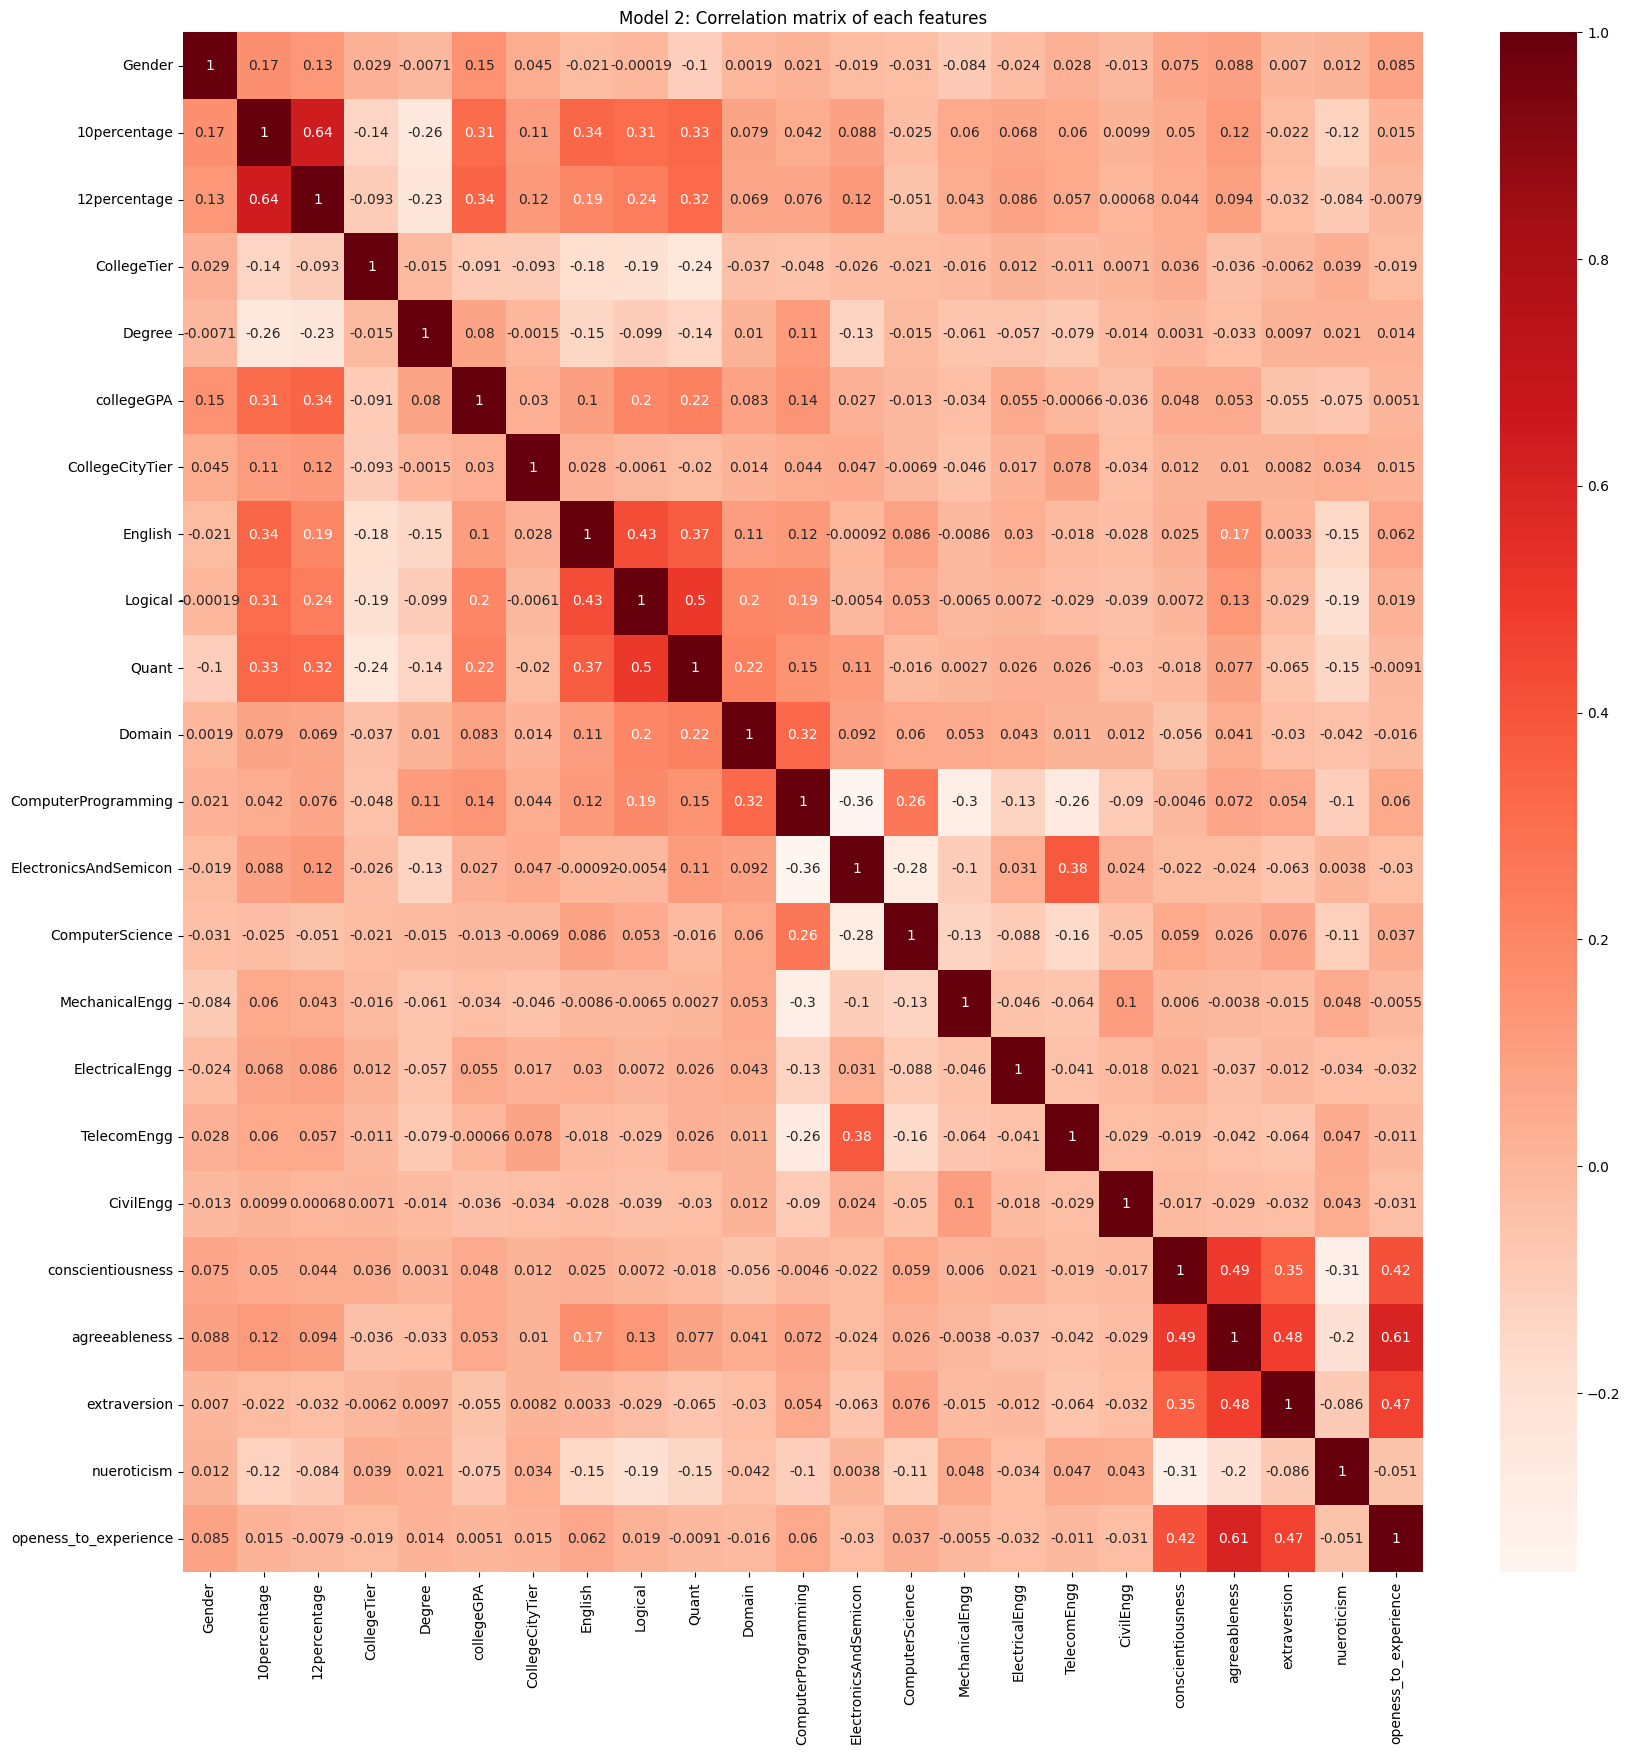

In [666]:
# Trình bày các phần tìm ra mô hình
#----------------------------------------------------------------------
    # Mô hình 2 (trực quan độ tương quan của các đặc trưng với nhau)
X_train = train.drop(['Salary'], axis=1)
Y_train = train['Salary']

X_test = test.drop(['Salary'], axis=1)
Y_test = test['Salary']
correlation_matrix = X_train.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.title('Model 2: Correlation matrix of each features')
plt.show()

    #Giá trị tương quan lớn nhất là 0.64,vì vậy em sẽ loại bỏ các đặc trưng có tương quan lớn hơn 0.5
    #Đảm bảo rằng loại bỏ được các đặc trưng có tương quan trong khoảng [0.5, 0.64]


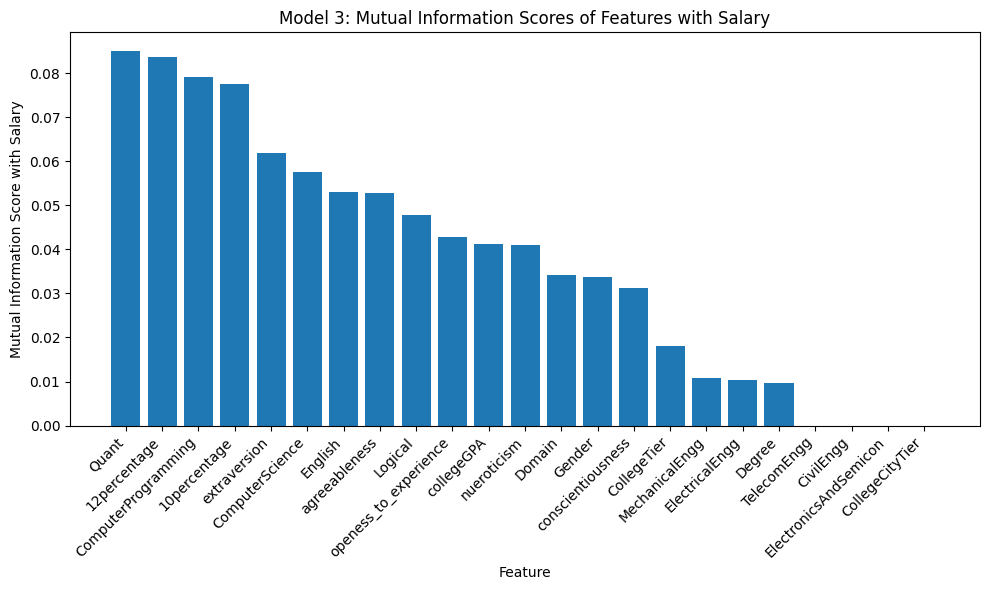

In [667]:
#----------------------------------------------------------------------
    # Mô hình 3 (trực quan độ tương hỗ thông tin của các đặc trưng với đặc trưng mục tiêu)
np.random.seed(0)

selected_top_columns = SelectPercentile(mutual_info_regression, percentile=70)
selected_top_columns.fit(X_train, y_train)

feature_scores = selected_top_columns.scores_

# Get the feature names
feature_names = X_train.columns

# Sort features and scores in descending order
sorted_indices = np.argsort(feature_scores)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_scores = [feature_scores[i] for i in sorted_indices]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(feature_names)), sorted_scores)
plt.xticks(np.arange(len(feature_names)), sorted_feature_names, rotation=45, ha='right')
plt.ylabel('Mutual Information Score with Salary')
plt.xlabel('Feature')
plt.title('Model 3: Mutual Information Scores of Features with Salary')
plt.tight_layout()

# Show the plot
plt.show()

    # Có thể thấy rằng từ đặc trưng "Quant" tới "CollegeTier" thì mức độ thông tin của các đặc trưng khá cao sao với phần còn lại.
    # Em quyết định sẽ lấy các đặc trưng trong khoảng đó, tức là khoảng 70% đặc trưng có mức độ thông tin cao nhất

### Building 3 models

In [668]:
#Model1 (Dropping constant feature)
# Loại bỏ các đặc trưng không thay đổi trong tập huấn luyện
# Cụ thể là giá trị phương sai >= 0.1
def model_variance_Dropping(X_train):
    var_thres = VarianceThreshold(threshold=0.1)
    var_thres.fit(X_train)
    constant_columns = [column for column in X_train.columns if column not in X_train.columns[var_thres.get_support()]]
    return constant_columns

#Model 2 (Dropping highly correlated)
#Xét độ tương quan giữa các đặc trưng (không xét đặc trưng muc tiêu)
#Nếu độ tương quan giữa 2 đặc trưng >= 0.5 thì xóa 1 trong 2 đặc trưng đó
def model_correlation_Dropping(X_train, threshold):
    col_corr = list()  # Set of all the names of correlated columns
    corr_matrix = X_train.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.append(colname)
    return col_corr

#Model 3 (Selecting highly mutual information)
#Xét tính tương hỗ giữa từng đặc trưng với đặc trưng mục tiêu
#Giữ lại 70% đặc trưng có tương hỗ cao nhất
def model_MutualInfor_selection(X_train, Y_train):
    np.random.seed(0)
    selected_top_columns = SelectPercentile(mutual_info_regression, percentile=70)
    selected_top_columns.fit(X_train, Y_train)

    select_feature = list(X_train.columns[selected_top_columns.get_support()].values)
    return select_feature


## Thử nghiệm, so sánh các mô hình

In [669]:
def cross_validation_model(Df_np, k_cluster):
    folks = np.array_split(Df_np, k_cluster) # split data to 10 folds
    mae_arr = np.zeros(k_cluster) # array to store mae of each fold
    for i in range(k_cluster):
        data_train = getTrain(i, folks) # get train data (9 folds except i-th fold)
        data_test = folks[i]            # get test data (i-th fold)

        X_test, y_test = data_test[:, :-1], data_test[:, -1]  #all features and salary in test data

        X_train, y_train = data_train[:, :-1], data_train[:, -1] #all features in each folds and salary in train data

        lr = OLSLinearRegression().fit(X_train, y_train) # fit model
        y_pre = lr.predict(X_test) # predict salary
        mae_arr[i] = mae(y_test, y_pre) # calculate mae of each fold
    return np.mean(mae_arr) # calculate mean of mae of 10 folds

### 1. Creating 3 models

In [670]:
model1 = model_variance_Dropping(X_train)
model2 = model_correlation_Dropping(X_train, 0.5)
model3 = model_MutualInfor_selection(X_train, y_train)
model3.append("Salary")

models = [model1, model2, model3]


### 2. Find and train best mode

In [671]:
# Phần code cho yêu cầu 1d
# Tìm ra mô hình tốt nhất (tự thiết kế bởi sinh viên)
# In ra các kết quả cross-validation như yêu cầu
def my_best_model(models):
    mae_avg_models = np.zeros(len(models))
    for i in range(len(models)):
        if i == 2:
            train_data = train.loc[:, models[i]]
        else:
            train_data = train.drop(models[i], axis=1)
        
        Df_np = train_data.to_numpy()
        np.random.default_rng().shuffle(Df_np, axis=0)
        mae_avg_models[i] = cross_validation_model(Df_np, 10)
    models_name = ["model 1", "model 2", "model 3"]
    result = []
    for mae, model in zip(mae_avg_models, models_name):
        result.append((model, mae))
    print("MAE AVG of each model: ")
    Df = pd.DataFrame(result, columns=["Model", "mae avg"])
    display(Df)
    return np.argmin(mae_avg_models)


model_index = my_best_model(models)
best_model = models[model_index]

if model_index == 2:
    best_model.remove('Salary')

print('Best model is model', model_index + 1, ':')
Df = pd.DataFrame(best_model, columns=["Features"])
display(Df)   


MAE AVG of each model: 


,Model,mae avg
0,model 1,111603.62083
1,model 2,111796.13096
2,model 3,110738.95299


Best model is model 3 :


,Features
0,Gender
1,10percentage
2,12percentage
3,CollegeTier
4,collegeGPA
5,English
6,Logical
7,Quant
8,Domain
9,ComputerProgramming


In [672]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện
def train_my_best_model():
    if model_index == 2:
        X_train, X_test = train[best_model].to_numpy(), test[best_model].to_numpy()
    else:
        X_train, X_test = train.drop(best_model, axis=1).to_numpy(), test.drop(best_model, axis=1).to_numpy()
    
    Y_train, Y_test = train.loc[:, 'Salary'], test.loc[:, 'Salary'].to_numpy()

    lr = OLSLinearRegression().fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)
    return Y_pred, Y_test

In [673]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
# In ra kết quả MAE trên tập kiểm tra
y_pred, y_test = train_my_best_model()
print("MAE of best model: ", mae(y_pred, y_test))

MAE of best model:  102431.57002986001


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = (-23438.408)*Gender + (887.524)*10percentage + (971.041)*12percentage + (-79706.706)*CollegeTier + (1689.069)*collegeGPA + (148.766)*English + \\(132.912)*Logical + (95.513)*Quant
+ (22104.286)*Domain + (104.259)*ComputerProgramming + (-164.058)*ComputerScience + (-20216.903)*conscientiousness\\ + (16789.581)*agreeableness + (5018.386)*extraversion + (-9649.493)*nueroticism
+ (-6317.617)*openess\_to\_experience
$$